# Audio2Blendshape test notebook

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scripts.Dataset import a2bsDataset
from scripts.SimpleNet import FaceGenerator, RMSLELoss

/home/tsekai/mambaforge/envs/beat/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Initialize train-eval-test split
Set *build_cache=True* to buid cache if it doesn't already exist.

In [2]:
train_data = a2bsDataset(loader_type='train', build_cache=False)
train_loader = torch.utils.data.DataLoader(
            train_data, 
            batch_size=16,  
            shuffle=True,  
            num_workers=0,
            drop_last=True,
        )

In [3]:
len(train_data)

6460

In [4]:
eval_data = a2bsDataset(loader_type='eval', build_cache=False)
eval_loader = torch.utils.data.DataLoader(
            eval_data, 
            batch_size=16,  
            shuffle=True,  
            num_workers=0,
            drop_last=True,
        )

In [5]:
len(eval_data)

1447

In [6]:
in_audio, facial, in_id = next(iter(train_loader))

In [7]:
print(in_audio.shape, facial.shape, in_id.shape)

torch.Size([16, 36266]) torch.Size([16, 34, 51]) torch.Size([16, 1])


In [8]:
net = FaceGenerator().cuda()
optimizer = torch.optim.Adam( net.parameters(), lr=1e-3, weight_decay=1e-5)
loss_function = RMSLELoss()
train_loss = []
eval_loss = []

In [11]:
num_epochs = 5
log_period = 100
eval_period = 400

for epoch in range(num_epochs):
    for it, (in_audio, facial, in_id) in enumerate(train_loader):
        net.train()
        in_audio = in_audio.cuda()
        facial = facial.cuda()
        pre_frames = 4
        in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
        in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
        in_pre_face[:, 0:pre_frames, -1] = 1 
        
        optimizer.zero_grad()
        out_face = net(in_pre_face,in_audio)
        loss = loss_function(facial, out_face)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()
        
        #logging
        if it % log_period == 0:
            print(f'[{epoch}][{it}/{len(train_loader)}] loss: {loss.item()}')
        
        if it % eval_period == 0:
            net.eval()
            eval_loss_st = []
            for _, (in_audio, facial, in_id) in enumerate(eval_loader):
                in_audio = in_audio.cuda()
                facial = facial.cuda()
                pre_frames = 4
                in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
                in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
                in_pre_face[:, 0:pre_frames, -1] = 1 

                out_face = net(in_pre_face,in_audio)
                loss = loss_function(facial, out_face)
                eval_loss_st.append(loss.item())
            
            eval_loss.append(np.average(eval_loss_st))
            print(f'[{epoch}][{it}/{len(train_loader)}] eval loss: {np.average(eval_loss_st)}')

[0][0/403] loss: 0.05984652787446976
[0][0/403] eval loss: 0.10455727767613199
[0][100/403] loss: 0.05872172862291336
[0][200/403] loss: 0.059605248272418976
[0][300/403] loss: 0.05729357525706291
[0][400/403] loss: 0.05684996396303177
[0][400/403] eval loss: 0.07509456297589673
[1][0/403] loss: 0.0649331659078598
[1][0/403] eval loss: 0.07852075658738614
[1][100/403] loss: 0.06454426795244217
[1][200/403] loss: 0.06420715898275375
[1][300/403] loss: 0.06254617869853973
[1][400/403] loss: 0.06478207558393478
[1][400/403] eval loss: 0.06823302730917931
[2][0/403] loss: 0.06107839569449425
[2][0/403] eval loss: 0.07132501287592782
[2][100/403] loss: 0.06341008096933365
[2][200/403] loss: 0.06438210606575012
[2][300/403] loss: 0.054657768458127975
[2][400/403] loss: 0.05939015746116638
[2][400/403] eval loss: 0.06638879113727146
[3][0/403] loss: 0.05323692783713341
[3][0/403] eval loss: 0.06984030856854385
[3][100/403] loss: 0.0611640103161335
[3][200/403] loss: 0.06252032518386841
[3][30

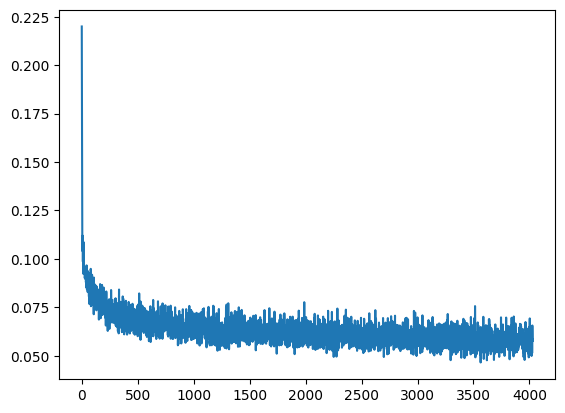

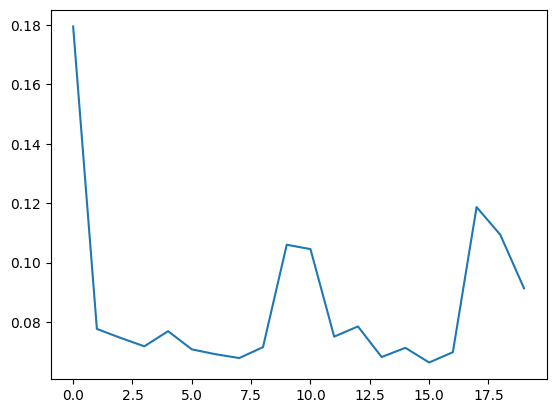

In [12]:
plt.plot(train_loss)
plt.show()
plt.plot(eval_loss)
plt.show()

In [98]:
net.eval()
in_audio, facial, in_id = next(iter(eval_loader))
in_audio = in_audio.cuda()
facial = facial.cuda()
pre_frames = 4
in_pre_face = facial.new_zeros((facial.shape[0], facial.shape[1], facial.shape[2] + 1)).cuda()
in_pre_face[:, 0:pre_frames, :-1] = facial[:, 0:pre_frames]
in_pre_face[:, 0:pre_frames, -1] = 1 
out_face = net(in_pre_face, in_audio)

In [99]:
out_face.shape, facial.shape

(torch.Size([1, 34, 51]), torch.Size([1, 34, 51]))

In [100]:
out_face[0,:,7]

tensor([0.2166, 0.2283, 0.2397, 0.2315, 0.2428, 0.2493, 0.2504, 0.2541, 0.2573,
        0.2609, 0.2718, 0.2830, 0.2924, 0.2983, 0.2963, 0.2858, 0.2360, 0.2100,
        0.1918, 0.2012, 0.2473, 0.2794, 0.2949, 0.2902, 0.2707, 0.2000, 0.2018,
        0.2292, 0.2660, 0.3031, 0.3274, 0.3392, 0.3476, 0.3398],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [101]:
facial[0,:,7]

tensor([0.2018, 0.1870, 0.1821, 0.1815, 0.1819, 0.1816, 0.1878, 0.1939, 0.1885,
        0.1680, 0.1425, 0.1257, 0.1093, 0.0941, 0.0808, 0.0839, 0.1211, 0.1340,
        0.1208, 0.1187, 0.1301, 0.1508, 0.1523, 0.1383, 0.1254, 0.1011, 0.0942,
        0.1182, 0.1292, 0.1447, 0.1581, 0.1300, 0.0912, 0.0982],
       device='cuda:0')

## Test set

In [11]:
test_data = a2bsDataset(loader_type='test', build_cache=False)
test_loader = torch.utils.data.DataLoader(
            test_data, 
            batch_size=16,  
            shuffle=True,  
            num_workers=0,
            drop_last=True,
        )

In [12]:
len(test_data)

660